# BLS MLflow Example Notebook 3- Scikit-Learn, Regression, & Tabular Data

*Remy Stewart, BLS Civic Digital Fellow Summer 2022*


# 1.0 Introduction
This example notebook expands from the first two Scikit-learn & MLflow intergration notebooks to explore a ML modeling workflow for a regression prediction task in contrast to the classification models featured in all of the other notebooks within this repository. This example draws from structured tabular data with a range of numeric and categorical variables in contrast to text data found within all of the other example notebooks. This raises different considerations and appropriate techniques regarding how to best employ MLflow to serve our goal of reproducibily tracking our regression analysis. Highlights of this example notebook includes its demonstration of how to search for both optimal hyperparameters and a best-performing model among multiple potential algorithms simulatenously via Scikit-learn's Pipeline module, how to incorperate feature selection in reference to regression performance metrics, and additional methods from the SHAP model interpretability library introduced within "Scikit-Learn, Random Forests, and SHAP" Example Notebook 2. 


## 1.1 Data & Model Goals
The public data featured in this notebook is sourced from the BLS' American Time Use Survey (ATUS) 2021 Well-Being module. This tabular survey data includes 6902 respondent records with features focusing on individual demographics, occupational characteristics, and personal well-being measures regarding health and life satisfaction. You'll find a data dictionary within the Data folder of this repository that provides further information on each of the features, their data types, and their respecitive values within our ATUS dataset. 

ATUS is the leading survey for measuring how Americans use their time within a given day on different activities such as personal care, work, and leisure. Our modeling goal is to predict the number of minutes spent on leisure activities within the past day for our module respondents. Qualifying activities for leisure time include socializing with family or friends, relaxing, pursuing personal interests, and watching TV.

We'll therefore start with loading in our standard libraries for a Mlflow-supported data science workflow along with a range of Scikit-learn modules suited for regression modeling on structured data. 

In [1]:
# Standard Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import operator
import os
import pickle
import tempfile
import shap
import re
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Sklearn modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

# MLflow Modules
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.shap
from mlflow.tracking import MlflowClient

%matplotlib inline 
sns.set()

We'll establish our connection to the remote BLS MLflow server, set a new experiment name for our ATUS regression project, and initialize our current model run. 

In [ ]:
mlflow.set_tracking_uri("http://<Remote IP>:<Port>")
mlflow.get_tracking_uri()

In [3]:
mlflow.set_experiment('reg-atus-experiment')

<Experiment: artifact_location='mlflow-artifacts:/13', experiment_id='13', lifecycle_stage='active', name='reg-atus-experiment', tags={}>

In [ ]:
run = mlflow.start_run(run_name="reg_atus_test")
print(f"Started run {run.info.run_id}")

# 2.0 Data Preprocessing

Let's load in our ATUS data and begin by exploring the characteristics of its features.

In [5]:
atus_wellbeing = pd.read_csv('../data/atus_wellbeing.csv')
atus_wellbeing.drop(columns=['caseid','work_min'], inplace=True)
atus_wellbeing

,hh_size,age,sex,race,hispanic,married,gen_health,educ_level,emp_status,worker_class,industry,spouse_emp,num_children,well_rested,life_satisfaction,leisure_min
0,1,51,M,White,1,0,Fair,Some College,Not in Labor Force,Not Applicable,Other Services,Not Applicable,0,A Little,5,430
1,4,56,M,White,0,1,Very Good,Professional/PhD,Employed,Private,Real Estate,Not Employed,0,Somewhat,8,130
2,2,16,F,Black,0,0,Excellent,Some HS,Not in Labor Force,Not Applicable,Other Services,Not Applicable,0,Not at all,9,410
3,2,15,F,Black,0,0,Good,Middle,Unemployed,Not Applicable,Other Services,Not Applicable,0,Somewhat,10,500
4,2,20,F,White,1,0,Good,Some College,Employed,Private,Other Services,Not Applicable,0,Very,7,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,2,56,M,White,0,1,Excellent,Bachelors,Employed,Private,Manufacturing- Non-Durable Goods,Employed,0,Very,9,255
6898,2,69,F,White,0,1,Very Good,Masters,Not in Labor Force,Not Applicable,Other Services,Not Employed,0,Very,8,706
6899,2,57,M,White,0,1,Excellent,Bachelors,Employed,Private,Manufacturing- Non-Durable Goods,Employed,0,Very,9,565
6900,4,34,F,White,0,1,Excellent,Bachelors,Employed,Private,Health Care & Social Services,Employed,2,A Little,9,270


We'll want to reference our numerical versus categorical variables multiple times throughout the script, so it'll be helpful to create designated lists that separate out the column names of the two feature types. We can log said reference lists directly as parameters within MLflow. 

In [6]:
categorical_columns = ['sex', 'race', 'gen_health', 'educ_level', 'emp_status', 'industry', 'worker_class', 'spouse_emp', 'well_rested']
mlflow.log_param('categorical_columns', categorical_columns)
numeric_columns = ['hh_size', 'age', 'num_children', 'life_satisfaction']
mlflow.log_param('numeric_columns', numeric_columns)

## 2.1 Descriptive Statistics & Visualizations

Pandas' `describe` function is a great method for obtaining statistics on the mean, standard deviation, and quartile ranges of our numerical data. While we can't store a Pandas DataFrame directly within MLflow, we can use the loophole of creating and saving our DataFrame as an HTML file within our model run's artifact directory to preserve this descriptive table. 

In [7]:
numeric_describe = atus_wellbeing.describe().round(2)

tempdir = tempfile.mkdtemp()
numerical_describe_path = os.path.join(tempdir, "numeric_describe.html")
numeric_describe.to_html(numerical_describe_path)
mlflow.log_artifact(numerical_describe_path)

numeric_describe

,hh_size,age,hispanic,married,num_children,life_satisfaction,leisure_min
count,6902.00,6902.00,6902.00,6902.00,6902.00,6902.00,6902.00
mean,2.54,51.57,3.87,0.49,0.50,7.31,311.62
std,1.45,18.35,29.99,0.50,0.95,1.94,219.49
min,1.00,15.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,36.00,0.00,0.00,0.00,6.00,145.00
50%,2.00,52.00,0.00,0.00,0.00,8.00,270.00
75%,4.00,67.00,0.00,1.00,1.00,9.00,445.00
max,14.00,85.00,244.00,1.00,8.00,10.00,1385.00


We can obtain equivalent descriptive information for our categorical features through passing the `include=object` argument into our `describe` method, which provides us with insights regarding how many unique categories are in each feature and what their most frequently occuring category value is within our dataset.

In [8]:
categorical_describe = atus_wellbeing.describe(include=object).round(2)

categorical_describe_path = os.path.join(tempdir, "categorical_describe.html")
categorical_describe.to_html(categorical_describe_path)
mlflow.log_artifact(categorical_describe_path)

categorical_describe

,sex,race,gen_health,educ_level,emp_status,worker_class,industry,spouse_emp,well_rested
count,6902,6902,6902,6902,6902,6902,6902,6902,6902
unique,2,5,5,8,3,5,10,3,4
top,F,White,Very Good,Bachelors,Employed,Private,Other Services,Not Applicable,Very
freq,3742,5553,2436,1719,4078,2974,3254,3131,2790


It can also be very helpful to explore the relationship between our features and target variable of spent leisure minutes visually. Let's draw from Seaborn's `PairGrid` module to consider all four of our numerical variable's variation with leisure minute values within side-by-side scatter plots, storing the aggregate plots within MLflow as well. 

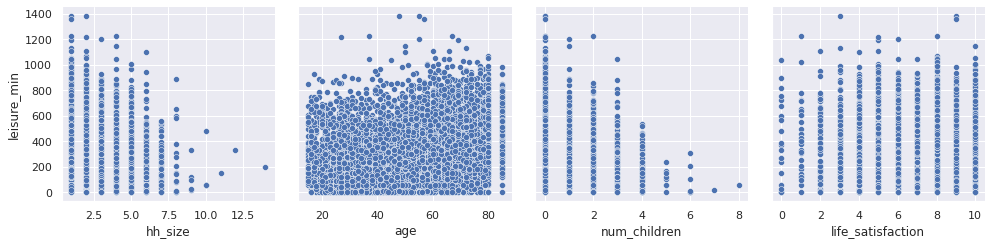

In [9]:
numeric_pairgrid = sns.PairGrid(atus_wellbeing, y_vars=["leisure_min"], x_vars=numeric_columns, height=3.5)
numeric_pairgrid.map(sns.scatterplot, edgecolor="white")

pairgrid_fig_path = os.path.join(tempdir, 'numeric_pairgrid.png')
numeric_pairgrid.savefig(pairgrid_fig_path)
mlflow.log_artifact(pairgrid_fig_path)

These scatterplot suggests that while age and life satisfaction ratings may not be too predictive of trends towards spent leisure minutes, there's definitely intial evidence that larger households and/or those with more children may spend less minutes on leisure activities within our data set. 

## 2.2 Numerical & Categorical Data Encoding

Given that we've done some initial recording of our data set and features, let's move forward with splitting up our data into training, testing, and prediction sets as well as transforming our features into proper formats for our following regression model. We'll need different techniques for the numerical and categorical features which we're able to combine by passing our respective transformers into a single Scikit-learn `ColumnTransformer` object. We'll use a `OneHotEncoder` to transform each of our categorical variables into suites of dummy columns while simultenously employing a `StandardScalar` to scale our numeric variables based on their means and unit variances.

The one-hot encoding of our categorical values will significantly increase our total count of features, so we'll save this feature count as our final feature dimensionality parameter within MLflow. We can also obtain the names of these newly-transformed features through our column transformer's `get_feature_names_out` method, which will be quite helpful later in our script for further examining indidivual feature importance. 

In [10]:
def split_and_process(atus_wellbeing, categorical_columns, numeric_columns):
    features_train, features_test, minutes_train, minutes_test = train_test_split(atus_wellbeing[atus_wellbeing.columns.difference(['leisure_min'])], 
                                                                                  atus_wellbeing['leisure_min'], test_size = 0.20, random_state = 607, shuffle=True)
    features_train, features_predict, minutes_train, minutes_predict = train_test_split(features_train, minutes_train, test_size = 0.02, random_state = 607, shuffle=True)

    test_names = features_test.columns
    column_trans = ColumnTransformer(transformers=
        [("oh", OneHotEncoder(), categorical_columns),
        ("std", StandardScaler(), numeric_columns)])

    features_train = column_trans.fit_transform(features_train)    
    features_test = column_trans.transform(features_test)
    feature_names = column_trans.get_feature_names_out()
    feature_names = [re.sub(r"(oh__|std__)", "", vals) for vals in feature_names]
    mlflow.log_param("Number of Features Following Column Transformations", len(feature_names))
    
    return features_train, features_test, features_predict, minutes_train, minutes_test, feature_names, column_trans

Following the creation of our data set splits and transformation of our variables, we'll want to save our `ColumnTransformer` within MLflow to reproduce our one-hot encoding and standardized scaling for future data transformations that may be passed into a reloaded version of our saved final model.

In [11]:
features_train, features_test, features_predict, minutes_train, minutes_test, feature_names, column_transformer = split_and_process(atus_wellbeing, categorical_columns, numeric_columns)

column_transformer_pickled = os.path.join(tempdir, "column_transformer.pkl")
pickle.dump(column_transformer, open(column_transformer_pickled, 'wb'))    
mlflow.log_artifact(column_transformer_pickled)

# 3.0 Model & Hyperparameter Cross-Validation Grid Search

Regression modeling such as attempting to predict minutes spent on leisure activities can be achieved by a wide range of ML algorithms. Exploring which of the many potential algorithms performs best on a given data set is a common task for data scientists that becomes further complicated by each of these algorithms having their own suite of tunable hyperparameters that can considerably impact their performance. This is a challenging decision point within machine learning experimentation that can be addressed through a range of techniques. I'll therefore highlight one approach that I believe effectively balances considering a wide selection of potential options regarding models and their hyperparameters with making a decision on a given model within a timely manner. 

We will conduct a 3-fold cross-validation search that simultenously considers three potential algorithms along with a suite of hyperparameter combinations. I've chosen three potential models for us that come from three different families of algorithms: 

- `ElasticNet` is a linear regression model that incorperates L1/LASSO and L2/Ridge reguralization parameters simultaneously. The tested hyperparameter `l1_ratio` designates how much weight is placed on the L1 term over the L2 term, while `max_iter` designates the iteration value cap when fitting the model. 
- `GradientBoostingRegressor` is a tree-based model that employs the ensemble method of boosting that improves later tree performance within the forest of estimators through improving on the prediction errrors of earlier trees. The model incorperates stoachastic gradient descent (SGD) via Adam optimization combined with the `learning_rate` parameter. `n_estimators` and `max_depth` are standard ensemble tree method hyperparameters regarding the count of individual trees fitted and their allowed depth via node splits. 
- `MLPRegressor`- standing for multi-layer perceptron- is a neural network algorithm that also employs SGD and Adam optimization similar to `GradientBoostingRegressor`. It is characterized by its 100 nodes within its single hidden layer designed to nonlinearly represent the feature space. The `alpha` hyperparameter sets the strength of an included L2 reguralization term, `learning_rate_init` designates the learning rate for SGD, and `max_iter` indicates how many passes the model can process the data through the network before making a final prediction. 

All three of these models employ feature selection through either explicit reguralization terms such as with `ElasticNet` and `MLPRegressor` or implicitly for `GradientBoostingRegressor` given the model's inherent feature-selection design via node split decisions. This will be helpful for exploring our suite of categorical and numerical features, in which only a select few among the many variables will likely significantly impact our model's performance. 

To prepare for this model-hyperparameter search, we first create a dictionary that maps each model to their tunable hyperparameter values. The `reg__` prefix before each hyperparameter ensures that the Scikit-learn `Pipeline` module that we're passing these parameters into to facilitate our search will be able to set each searched hyperparameter value into the tested regression model directly. 

In [12]:
search_params = [{'reg': [ElasticNet(random_state=607)],
                  'reg__l1_ratio': [0.3, 0.5, 0.8],
                  'reg__max_iter': [1000, 1500]},
                 {'reg': [GradientBoostingRegressor(random_state=607)],
                  'reg__n_estimators': [200, 400],
                  'reg__learning_rate': [0.01, 0.001],
                  'reg__max_depth': [3, 6]},
                 {'reg': [MLPRegressor(random_state=607)],
                  'reg__alpha': [0.0001, 0.001],
                  'reg__learning_rate_init': [0.001, 0.0001],
                  'reg__max_iter':[400, 700]}]

mlflow.log_param('ElasticNet Search Space', search_params[0])
mlflow.log_param('Gradient Boost Search Space', search_params[1])
mlflow.log_param('MLP Search Space', search_params[2])

We can then pass our specified `search_params` space into our `model_hyperparameter_search` function below. The function pairs each model and its associated hyperparameters into a Pipeline object fed into a `GridSearchCV` module, storing the identified best parameters as a dictionary within the results list. The list is then sorted to identify which of the three tuned models performed the best on the training data which is logged directly as parameters within MLflow. 

Since the cross-validation hyperparameter search is testing a range of hyperparameter combinations for three separate algorithms, the code block below will take some time to run. 

In [13]:
def model_hyperparameter_search(search_params):
    result=[]

    for params in search_params:
        reg = params['reg'][0]
        params.pop('reg')
        steps = [('reg', reg)]

        grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=3)
        grid.fit(features_train, minutes_train)

        result.append({'Model': grid.best_estimator_,
                       'Best Score': grid.best_score_,
                       'Best Params': grid.best_params_})

    #sorting result by best score
    result = sorted(result, key=operator.itemgetter('Best Score'),reverse=True)
    best_model = result[0]['Model']['reg']
    print('Best Performing Model', best_model)
    best_params = result[0]['Best Params']
    print('Best Performing Hyperparams', best_params)

    mlflow.log_param('Best Performing Model', best_model)
    mlflow.log_param('Best Performing Hyperparams', best_params)

In [14]:
model_hyperparameter_search(search_params)

Best Performing Model GradientBoostingRegressor(learning_rate=0.01, n_estimators=400,
                          random_state=607)
Best Performing Hyperparams {'reg__learning_rate': 0.01, 'reg__max_depth': 3, 'reg__n_estimators': 400}


Our search pipeline has selected the `GradientBoostingRegressor` with a 0.01 set learning rate, a 3-split tree depth, and 400 boosted tree estimators as its top performer within the search. 

# 4.0 Fitting the Best Performing Model

Following our identification of both the best performing model of a `GradientBoostingRegressor` along with its 
associated tuned hyperparameters, we're now ready to proceed with training our selected model.

We'll first create a function titled `prediction_plots` that will calculate the residuals between the actual leisure minutes spent by respondents within the testing set to the predicted minutes produced by our model. The function then creates paired scatter plots considering both the actual and predicted values as well as the predicted values to their residual differences. 

We'll draw on this helper function within our primary `model_fit` call that will train and test our `GradientBoostingRegressor`. We will employ root mean squared error (RMSE) and the R-squared model fit term as regression metrics to interpret our model's performance. 

In [15]:
def prediction_plots(minutes_test, estimates, title):
    df_preds = pd.DataFrame({'Actual': minutes_test.squeeze(), 'Predicted': estimates.squeeze()})
    df_preds['Residuals'] = df_preds['Actual'] - df_preds['Predicted']

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    sns.regplot(x = df_preds['Predicted'], y = df_preds['Actual'], scatter=True, ax=ax[0])
    sns.regplot(x = df_preds['Predicted'], y = df_preds['Residuals'], scatter = True, ax=ax[1])
    fig.suptitle(title)
    
    title_png = title + '.png'
    mlflow.log_figure(fig, title_png)

In [16]:
def model_fit(features_train, features_test, minutes_train, minutes_test):
    best_estimator = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=400, random_state=607)
    best_estimator_fitted = best_estimator.fit(features_train, minutes_train)
    estimates = best_estimator_fitted.predict(features_test)
    
    # Logging metrics
    rmse = np.sqrt(mean_squared_error(minutes_test, estimates))
    print("Base RMSE: ", rmse)
    mlflow.log_metric("Base RMSE", rmse) 
    r_squared_training = best_estimator_fitted.score(features_train, minutes_train)
    print("Base R-Squared Training: ", r_squared_training)
    mlflow.log_metric("Base R-Sqaured Training", r_squared_training) 
    r_squared_testing = best_estimator_fitted.score(features_test, minutes_test)
    print("Base R-Squared Testing: ", r_squared_testing)
    mlflow.log_metric("Base R-Sqaured Testing", r_squared_testing) 
    
    # Producing actual vs. predictions figure 
    prediction_plots(minutes_test, estimates, 'Base Model Prediction Performance')
    
    return best_estimator, estimates

Base RMSE:  194.17344746647458
Base R-Squared Training:  0.24797190341889708
Base R-Squared Testing:  0.19568826336555523


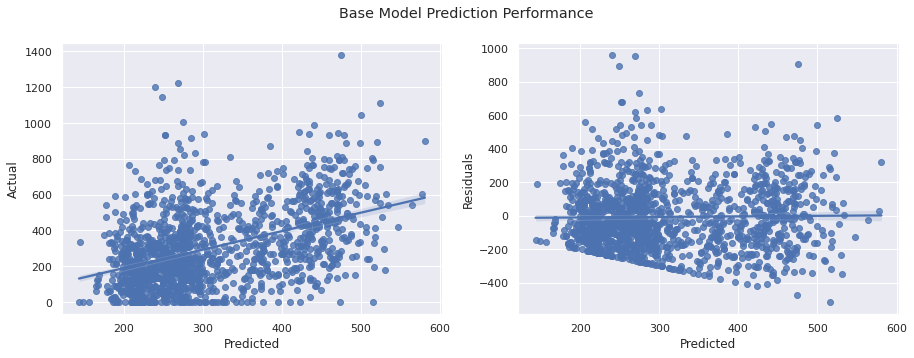

In [17]:
best_estimator, estimates = model_fit(features_train, features_test, minutes_train, minutes_test)

Our evaluation metrics and produced visuals provide helpful insight regarding our model's performance. The RMSE value of 194 implies an average error of 194 minutes towards predicting minutes of leisure time spent among the ATUS respondents. We can see from the plots comparing actual and residual values for prediction that our model struggles to predict minutes spent particlarly for respondents with a greater value of spent leisure minutes than expected by our model. This is at its root linked to the apparent high degree of variability of leisure minutes spent overall within the dataset that simply isn't fully explained by the features we have available from ATUS. 

Our R-square model fit on the testing set is slightly lower than the training, which is to be expected with non-overfitting models when predicting on unseen data. R-squared values for understanding social science phenomena such as leisure time spent among Americans consistently reports lower R-squared scores similiar to the ranges we're seeing with our model that regression models applied to less variable datasets regarding the natural and physical sciences. Either way, it'll be helpful to explore some alternative approaches to see if we can improve our model's performance further. 

## 4.1 Feature Importance

Let's investigate which of the categorical and numerical features within our ATUS data were the most important towards driving our model's predictions regarding the number of minutes spent on leisure activities. Our `GradientBoostingRegressor` model automatically produces `feature_importances_` values that we can convert into a helpful visual via a Seaborn barplot as follows.    

In [18]:
def importance_plot(best_estimator, feature_names): 
    feature_importances = pd.Series(best_estimator.feature_importances_, index=feature_names)
    top_features = feature_importances.sort_values(ascending=False)[:15]

    top_features.index = top_features.index.str.replace("oh__", "")
    top_features.index = top_features.index.str.replace("std__", "")
    plt.figure(figsize = (8,8))
    sns.barplot(x=top_features, y=top_features.index, orient='h')
    plt.xlabel('Feature Importance')
    
    importance_fig = os.path.join(tempdir, 'importance_fig.png')
    plt.savefig(importance_fig, bbox_inches="tight")
    mlflow.log_artifact(importance_fig)

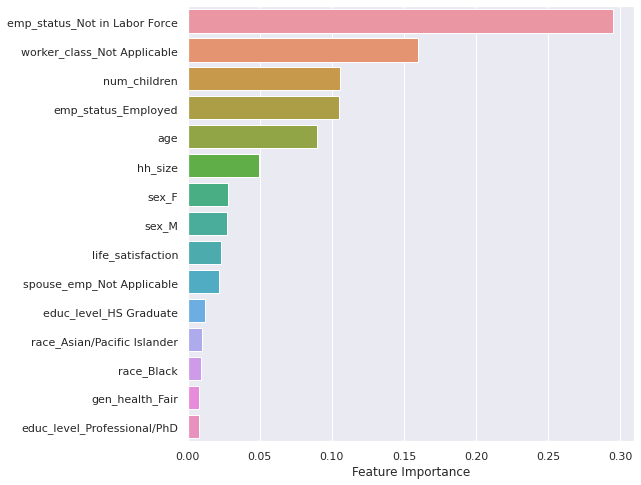

In [19]:
importance_plot(best_estimator, feature_names)

This figure provides us some interesting perspective regarding which features have the greatest influence towards our model's spent leisure minutes predictions. Being not in the labor force, in a non-applicable worker class (which is a category predominently applied to individuals not in the labor market), or one's value for employment status overall all report high importance. This strongly suggests that our model is learning that non-employment is predictive of more leisure time spent. Number of children and household size both likely proxy caretaking responsibilities that minimize available leisure time, while age is also likely connected to employment when considering middle-age adults contrasted to children or retirees. 

# 5.0 Feature Selection
The sizable drop in feature importance within a few values of our original 49 unique features lends support towards exploring further feature selection approaches that may reduce noise from less informative features and potentially improve our model's performance. While there's a range of potential feature selection methods to consider such as recursive elimination or dimensionality reduction via Principle Component Analysis (PCA), we'll explore the `SelectFromModel` technique provided within Scikit-learn as a selection strategy that preserves interpretability regarding which features have been selected. 

Scikit-learn refers to the `SelectFromModel` module as a "meta-transformer" that identifies features that are greater than a designated threshold of predictive influence and can subsequentially truncate feature training and test sets to keep only the identified higher-threshold features. `SelectFromModel` only supports linear models that produce additative coefficient terms or tree models that provide feature importance values like our `GradientBoostingRegressor`. Its default threshold value is the mean importance level identified by the base model fitted on all of the features, but this can be easily edited to consider alternative thresholds such as the median importance or any manually set scalar threshold value. 

In the following function we initialize a `SelectFromModel`transformer, retrieve the features the module identifies as passing the importance threshold, trim the feature training and testing sets to only include the selected features, refit our `GradientBoostingRegressor` on the truncated features, and then record its associated performance metrics all within MLflow. 

In [20]:
def feature_selection(features_train, features_test, minutes_train, minutes_test): 
    new_gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=400, random_state=607)
    selected_model = SelectFromModel(new_gbr).fit(features_train, minutes_train)
    selected_features = selected_model.get_feature_names_out(feature_names)
    print('Number of Features Selected:', len(selected_features))
    mlflow.log_param("Number of Features Selected:", len(selected_features))
    print('Selected Feature Labels:', selected_features)
    mlflow.log_param("Features found via Features Importance Selection", selected_features)

    features_train_trimmed = selected_model.transform(features_train)
    features_test_trimmed = selected_model.transform(features_test)
    
    new_gbr_fitted = new_gbr.fit(features_train_trimmed, minutes_train)
    estimates_trimmed = new_gbr_fitted.predict(features_test_trimmed)

    # Logging metrics
    rmse_trimmed = np.sqrt(mean_squared_error(minutes_test, estimates_trimmed))
    print("\nFeature Selected RMSE: ", rmse_trimmed)
    mlflow.log_metric("Feature Selected RMSE", rmse_trimmed) 
    r_squared_training_trimmed = new_gbr_fitted.score(features_train_trimmed, minutes_train)
    print("Feature Selected R-Squared Training: ", r_squared_training_trimmed)
    mlflow.log_metric("Feature Selected R-Sqaured Training", r_squared_training_trimmed) 
    r_squared_testing_trimmed = new_gbr_fitted.score(features_test_trimmed, minutes_test)
    print("Feature Selected R-Squared Testing: ", r_squared_testing_trimmed)
    mlflow.log_metric("Feature Selected R-Sqaured Testing", r_squared_testing_trimmed) 
    
    # Producing actual vs. predictions figure 
    prediction_plots(minutes_test, estimates, 'Feature Selection Model Prediction Performance')

Number of Features Selected: 10
Selected Feature Labels: ['sex_F' 'sex_M' 'emp_status_Employed' 'emp_status_Not in Labor Force'
 'worker_class_Not Applicable' 'spouse_emp_Not Applicable' 'hh_size' 'age'
 'num_children' 'life_satisfaction']

Feature Selected RMSE:  195.22020128897813
Feature Selected R-Squared Training:  0.23373504381190569
Feature Selected R-Squared Testing:  0.1869930920632623


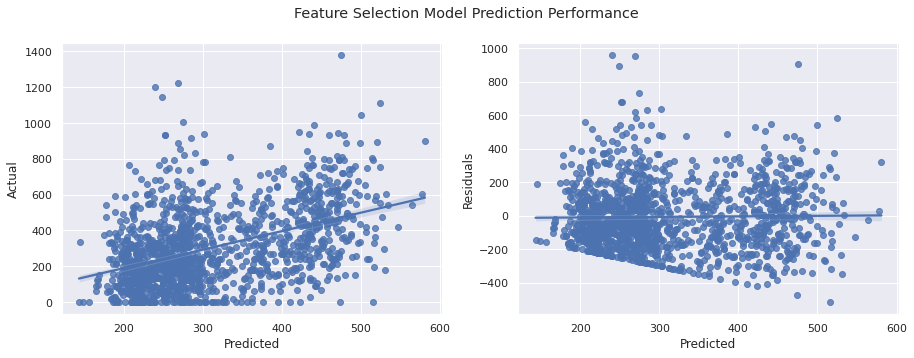

In [21]:
feature_selection(features_train, features_test, minutes_train, minutes_test)

The selected features via the `SelectFromModel` meta-transformer line up closely to the features highlighted within our feature importance bar chart. 

If we review our Metrics output directly within the MLflow UI for our current model run, we can see that the baseline model without feature section achieved marginally better performance than the `GradientBoostingRegressor` reduced from the original 49 features to the 10 selected features on values such as RMSE and the R-squared term:

![metrics.png](../imgs/metrics.png)

This suggests that we should continue with the original model as our final model to log within MLflow. 

## 5.1 Logging the Final Model 

Since we already have the `best_estimator` object preserving our baseline model, we can easily save the model into the remote server via `mlflow.sklearn.log_model`. We additionally employ `infer_signature` to have our model require all 49 of the original features following their one-hot encoding and standardized scaling to be included within future passed data before generating new predictions. 

In [22]:
mlflow.log_params(best_estimator.get_params())
signature = mlflow.models.infer_signature(features_train, estimates)
mlflow.sklearn.log_model(best_estimator, "reg_atus_model", conda_env="../conda.yaml", signature=signature,
                         registered_model_name="reg_atus")
mlflow.log_artifact("sklearn_regression_example_3.ipynb")

# 6.0 SHAP Explanations
Our regression modeling workflow provides another great opportunity to explore model interpretation visualizations powered by the SHAP library. Please refer to the second example notebook for a more comprehensive overview of SHAP and Shapley values. Within this notebook we'll instead focus on exploring different SHAP methods from those highlighted in the previous example walkthrough and how said techniques can aid our understanding of which ATUS features have the greatest impact on our model's predictions of spent leisure minutes.

We initialize a `shap.TreeExplainer`, generate the SHAP values for our test data, and save our explainer in MLflow as follows. 

In [23]:
explainer = shap.TreeExplainer(model=best_estimator, feature_perturbation='tree_path_dependent')
shap_val_explanations = explainer(features_test.toarray())

shap_pickled = os.path.join(tempdir, "shap_explainer.pkl")
pickle.dump(explainer, open(shap_pickled, 'wb'))    
mlflow.log_artifact(shap_pickled)

The baseline feature importance outputs computed for our `GradientBoostedRegressor` is based on information gain, which is a metric susceptable to variation due to the inherently stochastic nature of the algorithm regarding which variables are used to create splits and at what depth within the tree a given feature is selected. SHAP instead averages importance across all possible combinations of features towards producing a final prediction of leisure minutes spent. It may therefore produce different values regarding feature importances than what is provided as an output of fitted Scikit-learn tree models, but there's a strong argument to be made that the generated SHAP values are more robust against variability in model results overall. 

We can use the `shap.summary_plot` method to obtain the SHAP equivalent of global feature importance regarding our `GradientBoostedRegressor`'s generated leisure minute predictions on the test set. 

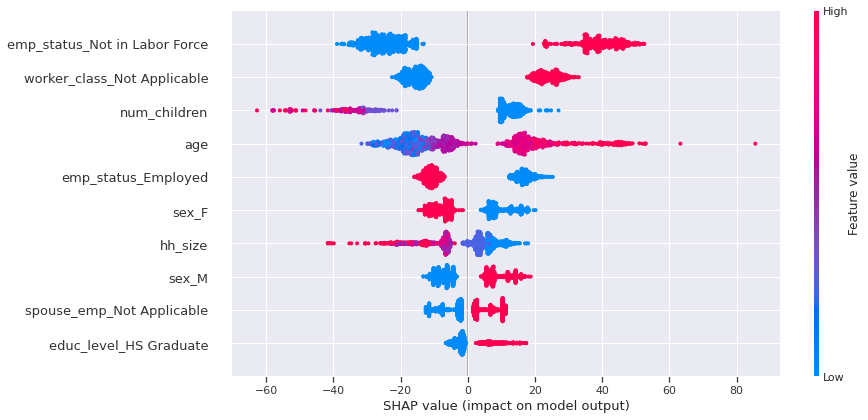

In [24]:
summary_plot = shap.summary_plot(shap_val_explanations.values, features_test.toarray(), max_display=10, 
                                  feature_names=feature_names, plot_size=[13,6], show=False)

summary_plot_path = os.path.join(tempdir, "summary_plot.png")
plt.savefig(summary_plot_path)
mlflow.log_artifact(summary_plot_path)
plt.show()

Negative SHAP values means that the feature taking the specified value is associated with a smaller amount of spent leisure time, while a positive SHAP value indicates a higher degree of spent leisure time. This is concurrently interacted with the different possible feature values themselves, with the "high" and "low" coloration provided by SHAP referring to either a 1 or 0 code for the dummy variables respectively. 

SHAP overall corroberates on what we concluded from the `GradientBoostingRegressor` baseline feature importance metrics. Being not in the labor force or older is linked to more leisure minutes for a respondent, while having a larger household or more children is predictive of less leisure minutes spent. It additionally provides us further insight towards men spending more leisure minutes than women, and being a high school graduate as associated with more leisure time.

A SHAP visualization that provides us with a local interpretation towards the predicted value of one ATUS respondent is `shap.plots._waterfall`. Waterfall plots visualize how a respondent's values for each of the features subsequently impacts the model's prediction of leisure minutes spent for the individual.  

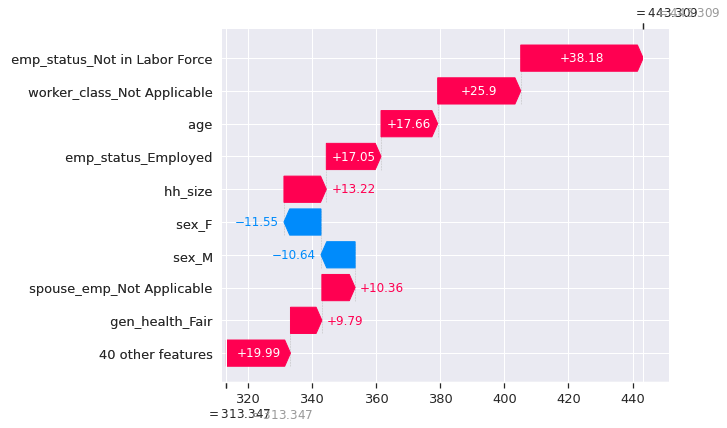

In [25]:
waterfall_plot = shap.plots._waterfall.waterfall_legacy(shap_val_explanations[0].base_values[0], shap_val_explanations[0].values, features=shap_val_explanations[0].data, feature_names=feature_names, show=False)
waterfall_plot_path = os.path.join(tempdir, 'waterfall_plot.png')
plt.savefig(waterfall_plot_path, bbox_inches="tight")
mlflow.log_artifact(waterfall_plot_path)

The first plot that demarcates how different values of a given variable influence the SHAP value directionality is quite helpful for interpreting the meaning behind this waterfall plot's results regarding this particular ATUS respondent. The reported values suggest that this respondent is likely an older woman who is not currently employed and does not live in a large household. These feature values leads to a final model prediction of 443 spent leisure minutes for this respondent rather than the mean value of 313 minutes.  

We've now gathered a wide range of parameters, metrics, tables, figures, and our logged model all within our model run within MLflow, so we can now proceed with ending the run. 

In [26]:
mlflow.end_run()

# 7.0 Testing Model Predictions

We'll finish this example notebook with the same final check featured throughout the provided MLflow intergration examples of reloading in the logged model from MLflow and testing its ability to produce predictions on a held-out data set. We'll reload and test our saved SHAP explainer on our held-out prediction set as well. 

In [27]:
client = MlflowClient()
registered_model = mlflow.pyfunc.load_model(model_uri="models:/reg_atus/1")

column_transformer_path = client.download_artifacts("<Model Path>", "column_transformer.pkl", tempdir)
column_transformer = pickle.load(open(column_transformer_path, 'rb'))

shap_explainer_path = client.download_artifacts("<Model Path>", "shap_explainer.pkl", tempdir)
shap_explainer = pickle.load(open(shap_explainer_path, 'rb'))

Our column transformation pipeline featuring both one-hot encoding and standardized scaling is reproduced on the prediction data and then successfully fed into the reloaded `GradientBoostedRegressor` model to produce new spent leisure time predictions.

In [28]:
features_pred_vectorized = column_transformer.transform(features_predict)
features_pred_vectorized

<111x49 sparse matrix of type '<class 'numpy.float64'>'
	with 1443 stored elements in Compressed Sparse Row format>

In [29]:
registered_model.predict(features_pred_vectorized)

array([306.79589981, 409.58662213, 446.80714196, 256.0585642 ,
       258.32387225, 264.15175039, 374.39067637, 389.27229531,
       206.53316823, 264.16327341, 199.67429392, 299.52676963,
       446.5476396 , 276.43028242, 246.40417197, 241.65260014,
       256.42073649, 217.27360764, 276.03122489, 376.7136082 ,
       303.69174915, 215.43355942, 267.44289672, 421.16776391,
       248.02820392, 324.4476768 , 209.72087043, 262.15218509,
       373.97663266, 204.54606037, 473.50637066, 502.43008475,
       433.44323749, 276.41166022, 226.63886277, 261.94940815,
       263.44440816, 422.58688762, 401.71167798, 221.25781033,
       335.07024235, 246.14488518, 257.65998018, 229.61877484,
       267.34617831, 307.30599873, 455.4225986 , 227.76107342,
       454.7546548 , 215.54632142, 246.89210393, 524.32344215,
       280.25198282, 231.12142854, 247.76241606, 202.18988555,
       423.85719408, 201.92788553, 215.906453  , 237.77966316,
       498.07393739, 260.99249019, 396.00600113, 218.92

With our model successfully generating new predictions on leisure minutes, let's additionally test the reproducibility of our SHAP explainer through generating another waterfall plot on the first respondent within the prediction set.

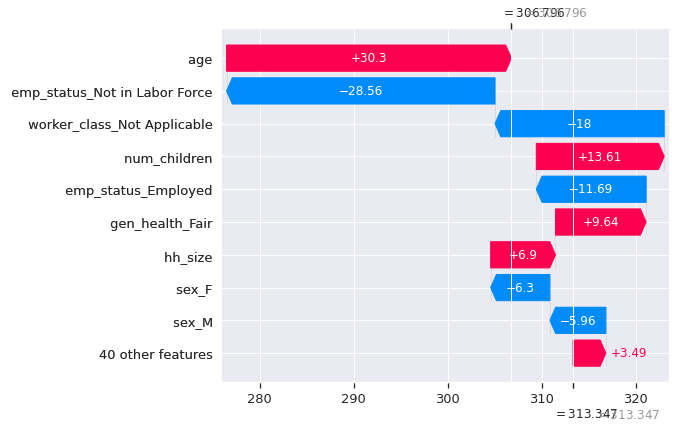

In [30]:
shap_pred_values = shap_explainer(features_pred_vectorized.toarray())
shap.plots._waterfall.waterfall_legacy(shap_pred_values[0].base_values[0], shap_pred_values[0].values, features=shap_pred_values[0].data, feature_names=feature_names)

Our new waterfall plot is successfully generated, and we can therefore confirm that we've produced a robust regression model workflow on the ATUS tabular data set that is comprehensively logged within our MLflow server for future retrieval and overall reproducibility. 